In [502]:
import numpy as np 
import pandas as pd 

In [503]:
students = pd.read_csv("students.csv")
exams = pd.read_csv("exams.csv")
enrolments = pd.read_csv("enrolements.csv")
rooms = pd.read_csv("indexed_rooms.csv")
slots= pd.read_csv("slots.csv")

In [504]:
class Exam:
    def __init__(self, exam_code, name, duration, department_code):
        self.code = exam_code
        self.name = name
        self.duration = duration
        self.duration_min = 0
        self.dep_code = department_code
        self.conflicts = 0
        self.exam_conflicts = set()
        self.priority = 0
        self.slot = -1
        self.student_codes = []
        self.students = []
        self.rooms = []
        self.room_assigned = False
        self.disability_requirement = False
        self.students_disabled = []
        self.students_assigned = 0

class Student:
    def __init__(self, student_code, course_code, disability):
        self.code = student_code
        self.course_code = course_code
        self.disability = disability
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code):
        self.student_code = student_code
        self.exam_code = exam_code

class Room:
    def __init__(self, index, room_code, capacity, disabled_suitability):
        self.index = index
        self.code = room_code
        self.capacity = capacity
        self.status = False
        self.disabled_suitability = disabled_suitability
        self.seats_occupied = 0
class Slot:
    def __init__(self, index, date, day, type):
        self.index = index
        self.date = date
        self.day = day
        self.type = type
        self.exams = []
        self.student_count = 0
class RoomSlotMap:
    def __init__(self, slot, room, exams, capacity):
        self.slot = slot
        self.room = room
        self.capacity = capacity
        self.exams = exams

In [505]:
exam_objects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

student_objects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolment_objects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

room_objects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

slot_objects = [Slot(**kwargs) for kwargs in slots.to_dict(orient='records')]

In [506]:
for i in enrolment_objects:
    for j in student_objects:
        if j.code == i.student_code:
            j.exam_codes.append(i.exam_code)

In [507]:
for i in student_objects:
    for j in exam_objects:
        for k in i.exam_codes:
            if k == j.code:
                i.exams.append(j)

In [508]:
for i in enrolment_objects:
    for j in exam_objects:
        if j.code == i.exam_code:
            j.student_codes.append(i.student_code)

In [509]:
for i in exam_objects:
    for j in student_objects:
        for k in i.student_codes:
            if k == j.code:
                i.students.append(j)

In [510]:
for i in exam_objects:
    for j in i.students:
        if j.disability == True:
            i.disability_requirement = True
            i.students_disabled.append(j)

In [511]:
def getRoomKey(obj):
    return obj.capacity

In [512]:
roomSlotArr = []
for i in slot_objects:
    for j in sorted(room_objects, key=getRoomKey):
        roomSlotArr.append([i, j, [], j.capacity])

In [513]:
roomSlotArrDF = pd.DataFrame(roomSlotArr, columns = ["slot", "room", "exams", "capacity"])
roomSlotMapObjects = [RoomSlotMap(**kwargs) for kwargs in roomSlotArrDF.to_dict(orient='records')]

In [514]:
def hhToSeconds(s):
    t = 0
    splitTime = s.split(':')
    t = 60 * int(splitTime[0]) + int(splitTime[1])
    return t

In [515]:
for i in exam_objects:
    i.duration_min = hhToSeconds(str(i.duration))

In [516]:
def degreeOfConflict(exam):
    s = set()
    for i in exam.students:
        for j in i.exams:
            if exam.code != j.code:
                s.add(j)
    exam.exam_conflicts = s
    return len(s)

In [517]:
for i in exam_objects:
    i.conflicts = degreeOfConflict(i)

In [518]:
def partialExamOrdering():
    sup = np.zeros(len(exam_objects))
    for i in range(len(exam_objects)):
        for j in range(len(exam_objects)):
            if exam_objects[i].conflicts > exam_objects[j].conflicts:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].conflicts < exam_objects[j].conflicts:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students) > len(exam_objects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students) < len(exam_objects[j].students):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].duration_min > exam_objects[j].duration_min:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].duration_min < exam_objects[j].duration_min:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students_disabled) > len(exam_objects[j].students_disabled):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students_disabled) < len(exam_objects[j].students_disabled):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].code > exam_objects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif exam_objects[i].code < exam_objects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup                               

In [519]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(exam_objects)):
        exam_objects[i].priority = partialExamOrder[i]  

In [520]:
def getKey(obj):
    return obj.priority

In [521]:
pheromoneMatrix = np.zeros((len(exam_objects), len(slot_objects), len(room_objects)))

def updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE):
    for i in range(len(exam_objects)):
        for j in range(len(slot_objects)):
            for k in range(len(room_objects)):
                if exam_objects[i].slot.index == slot_objects[j].index and exam_objects[i].room == room_objects[k]:
                    pheromoneMatrix[i][j][k] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j][k] + 1
                else:
                    pheromoneMatrix[i][j][k] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j][k]
                if pheromoneMatrix[i][j][k] < t_min:
                    pheromoneMatrix[i][j][k] = t_min
                elif pheromoneMatrix[i][j][k] > t_max:
                    pheromoneMatrix[i][j][k] = t_max
    
def initPheromoneMatrix(exams, slots, rooms, value):
    for i in range(len(exams)):
        for j in range(len(slots)):
            for k in range(len(rooms)):
                pheromoneMatrix[i][j][k] = value
       

In [522]:
heuristicsMatrix = np.zeros((len(exam_objects), len(slot_objects), len(room_objects), 3))

def initHeuristicsMatrix(exams, slots, rooms):
    for i in range(len(exams)):
        for j in range(len(slots)):
            for k in range(len(rooms)):
                heuristicsMatrix[i][j][k] = [1, rooms[k].index, rooms[k].capacity]


In [523]:
def checkForHardConstraintViolations(exam, slot, room):
    score = 0
    for i in exam.exam_conflicts:
            if i.slot != -1:
                if i.slot.index == slot.index:
                    score += 4
                elif np.abs(i.slot.index - slot.index) < 2:
                    score += 4
    if slot.index == 12:
        score += 4
    if slot.index % 3 == 0 and exam.duration_min > 90:
        score += 4
    if len(exam.students) + slot.student_count > 2653:
        score += 4
    if len(exam.students) > room.capacity:
        score += 4
    if room.seats_occupied + len(exam.students) > room.capacity:
        score += 4
    return score
                    

In [524]:
def numIncentive(exam, slot, room):
    score = 0
    if slot.index % 3 == 0 and exam.duration_min <= 90:
        score += 4
    return 0

In [525]:
def checkForSoftConstraintViolations(exam, slot, room):
    score = 0
    for i in exam.exam_conflicts:
        if i.slot != -1:
            if np.abs(i.slot.index - slot.index) < 3:
                score += 1
    return score

In [526]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(slot_objects[11])
    for i in exam.exam_conflicts:
        if i.slot != -1 and i.code != exam.code:
            forbiddenSlots.add(i.slot)
    return forbiddenSlots

In [527]:
def numAdditionalViolations(exam, slot, room):
    score = 0
    score += checkForHardConstraintViolations(exam, slot, room)
    score += checkForSoftConstraintViolations(exam, slot, room)
    return score

In [528]:
def pheroHeuristicSummation(examIndex, slotIndex, roomIndex, alpha, beta):
    sum = 0
    for j in range(len(slot_objects)):
        for k in range(len(room_objects)):
            if j != slotIndex and k != roomIndex:
                sum += (pheromoneMatrix[examIndex][j][k]**alpha) * (heuristicsMatrix[examIndex][j][k]**beta)
    return sum

In [529]:
def chooseSlot(examIndex, exam, slots, rooms, alpha, beta):
    slot = 0
    room = []
    desirability = np.zeros((len(slots), len(rooms)))
    forbiddenSlots = list(findForbiddenSlots(exam))
    for i in range(len(slots)):
        for k in range(len(rooms)):
            #print(str(i) + ", " + str(k))
            heuristicsMatrix[examIndex][i][k][0] = (1 + numIncentive(exam, slots[i], rooms[k])) / (1 + numAdditionalViolations(exam, slots[i], rooms[k]))
            #print(str(heuristicsMatrix[examIndex][i][k]))
            desirability[i][k] = ((pheromoneMatrix[examIndex][i][k]**alpha) * (heuristicsMatrix[examIndex][i][k][0]**beta))
            #/pheroHeuristicSummation(examIndex, slots[i], rooms[k], alpha, beta)
            for j in forbiddenSlots:
                if slot_objects[i].index == j.index:
                    desirability[i][k] = -1
                    continue
            if heuristicsMatrix[examIndex][i][k][2] <= 0:
                desirability[i][k] = -1
            argSortedList = np.flip(np.dstack(np.unravel_index(np.argsort(desirability.ravel()), desirability.shape))[0])
            #print("Length: " + str(argSortedList[0]))
            slot = argSortedList[0][1]
            ind = 0
            while exam.students_assigned < len(exam.students) and ind < len(argSortedList):
                room.append(rooms[argSortedList[ind][0]])
                
                if len(exam.students) - exam.students_assigned > rooms[argSortedList[ind][0]].capacity:
                    rooms[argSortedList[ind][0]].seats_remaining -= (len(exam.students) - exam.students_assigned)
                    exam.students_assigned += rooms[argSortedList[ind][0]].capacity
                elif len(exam.students) - exam.students_assigned < rooms[argSortedList[ind][0]].capacity:
                    exam.students_assigned += len(exam.students) - exam.students_assigned
                    rooms[argSortedList[ind][0]].seats_remaining -= exam.students_assigned
                ind += 1
    return slots[slot], room

In [530]:
def evaluateHardConstraints():
    countHard = 0
    examsChecked = []
    index = 0
    for i in slot_objects:
        if i.student_count > 2653:
            countHard += 1
    for i in room_objects:
        if i.seats_occupied > i.capacity:
            countHard += 1
    while index < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if k == j:
                    flag = True
            if flag:
                continue
            else:
                if exam.slot.index == j.slot.index:
                        countHard += 1
                elif np.abs(exam.slot.index - j.slot.index) < 2:
                    countHard += 1
        if exam.slot.index == 12:
            countHard += 1
        if exam.slot.index % 3 == 0 and exam.duration_min > 90:
            countHard += 1
        index += 1
        examsChecked.append(exam)
    return countHard

In [531]:
def evaluateSoftConstraints():
    countSoft = 0
    examsChecked = []
    index = 0
    while index  < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if  k == j:
                    flag = True
            if flag:
                continue
            else:
                if np.abs(exam.slot.index - j.slot.index) < 3:
                    countSoft += 1
        index += 1
        examsChecked.append(exam)
    return countSoft

In [532]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

In [533]:
def getMapKey(obj):
    return obj.capacity

In [534]:
room_max_capacity = room_objects[0]
for i in room_objects:
    if room_max_capacity.capacity < i.capacity:
        room_max_capacity = i

In [535]:
def assignSlotsForSolution(solution):
    for i in slot_objects:
        i.exams = []
        i.student_count = 0
    for i in exam_objects:
        i.rooms = []
    for i in solution:
        list(i)[0].slot = list(i)[1]
        list(i)[0].rooms.append(list(i)[2])
        list(i)[1].exams.append(list(i)[0])
        list(i)[1].student_count += len(list(i)[0].students)
        #list(i)[2].seats_occupied += len(list(i)[0].students)

In [536]:
EVAPORATION_RATE = 0.2
numAnts = 3
t_max = 5.0
t_min = 0.0019
MAX_ITER = 10
alpha = 1.0
beta = 4.0

In [539]:
index = 0
initPheromoneMatrix(exam_objects, slot_objects, room_objects, t_max)
initHeuristicsMatrix(exam_objects, slot_objects, room_objects)
#heuristicsMatrix[0][0][0] = [1, 1,10]
totalConflictsForExams()
#sortedExamsByPriority = sorted(exam_objects, key=getKey, reverse=True)
evaluationSoftMap = []
evaluationHardMap = []
A_gb = set()
prevScore = 0
while index < MAX_ITER:
    A_ib = set()
    prevScoreAnt = 0
    #initHeuristicsMatrix(exam_objects, slot_objects, room_objects)
    for k in range(numAnts):
        #initHeuristicsMatrix(exams, slot_objects, room_objects)
        A = set()
        chosenSlot = 0
        for i in range(len(exam_objects)):
            exam_objects[i].slot = -1
            exam_objects[i].room = []
            exam_objects[i].students_assigned = 0
        for i in slot_objects:
            i.student_count = 0
        for i in room_objects:
            i.seats_occupied = 0
            i.seats_remaining = i.capacity
        for i in range(len(exam_objects)):
            chosenSlot = chooseSlot(i,exam_objects[i], slot_objects, room_objects, alpha, beta)
            exam_objects[i].slot = chosenSlot[0]
            exam_objects[i].rooms.append(chosenSlot[1])
            chosenSlot[0].student_count += len(exam_objects[i].students)
            print(exam_objects[i].code + ": || $lot:" + str(chosenSlot[0].index) + ": || students: " + str(len(exam_objects[i].students)) + " ||Rooms: " + str(len(exam_objects[i].rooms)) + "|| Total: " + str(chosenSlot[0].student_count))
            A.add((exam_objects[i], chosenSlot[0], tuple(chosenSlot[1])))
        print("------------------------------END ANT ITER--------------------------------")
        assignSlotsForSolution(A)
        scoreAl = evaluate()[0] *4 + evaluate()[1]
        if A_ib != set():
            A_ib = A if scoreAl < prevScoreAnt else A_ib
            prevScoreAnt = scoreAl if scoreAl < prevScoreAnt else prevScoreAnt
        else:
            A_ib = A
            prevScoreAnt = scoreAl
    assignSlotsForSolution(A_ib)
    scoreA_ibl = evaluate()[0]*4 + evaluate()[1]
    if A_gb != set():
        A_gb = A_ib if scoreA_ibl < prevScore else A_gb
        prevScore = scoreA_ibl if scoreA_ibl < prevScore else prevScore
    else:
        A_gb = A_ib
        prevScore = scoreA_ibl
    assignSlotsForSolution(A_gb)
    updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE)
    evaluationSoftMap.append((index, evaluate()[0]))
    evaluationHardMap.append((index, evaluate()[1]))
    print("---|||Iteration :" + str(index) + " complete.|||---")
    index += 1

ValueError: setting an array element with a sequence.

In [538]:
heuristicsMatrix[0][0][0]

array([ 1.,  1., 10.])

In [ ]:
prevScore

542

<AxesSubplot:xlabel='Iterations'>

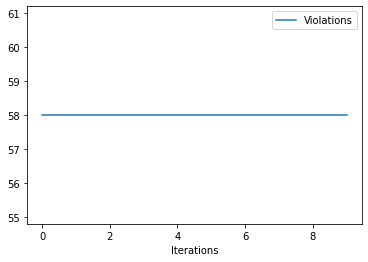

In [ ]:
evalHardDF = pd.DataFrame(evaluationHardMap, columns=['Iterations', 'Violations'])
evalHardDF.plot.line(x='Iterations', y='Violations')

<AxesSubplot:xlabel='Iterations'>

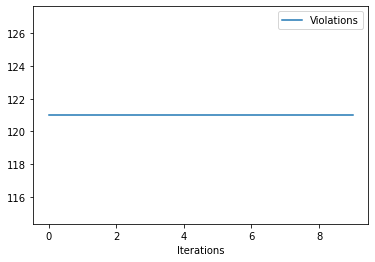

In [ ]:
evalSoftDF = pd.DataFrame(evaluationSoftMap, columns=['Iterations', 'Violations'])
evalSoftDF.plot.line(x='Iterations', y='Violations')

In [ ]:
studentArr = []
for i in student_objects:
    for j in i.exams:
        studentArr.append([i.code, j.code, j.slot.index, j.slot.day, j.slot.type, j.duration, len(j.students), j.rooms])

In [ ]:
pd.DataFrame(studentArr).to_csv('student_output_1.csv')

In [ ]:
examArr = []
for i in exam_objects:
    roomArr = []
    for j in list(i.rooms)[0]:
        roomArr.append(j.code)
    examArr.append([i.code, i.slot.index, i.slot.day, i.slot.type, i.duration, len(i.students), roomArr])

In [ ]:
for j in list(exam_objects[0].rooms)[0]:
    print(j)

In [ ]:
pd.DataFrame(examArr).to_csv('exam_output.csv')

In [ ]:
slotsUsed = set()
for i in slot_objects:
    examsAtslot = []
    print("Slot: " + str(i.index))
    for j in exam_objects:
        if i.index == j.slot.index:
            #print(j.code)
            examsAtslot.append([i.index, j.code, str(len(j.exam_conflicts))])
    print(len(examsAtslot))

Slot: 1
49
Slot: 2
17
Slot: 3
25
Slot: 4
30
Slot: 5
19
Slot: 6
30
Slot: 7
34
Slot: 8
28
Slot: 9
19
Slot: 10
17
Slot: 11
40
Slot: 12
0
Slot: 13
17
Slot: 14
86
Slot: 15
26
Slot: 16
10
Slot: 17
38
Slot: 18
31
Slot: 19
22
Slot: 20
23
Slot: 21
38
Slot: 22
24
Slot: 23
21
Slot: 24
30
Slot: 25
19
Slot: 26
18
Slot: 27
89


In [ ]:
longExams = []
shortExams = []
for i in exam_objects:
    if i.duration_min > 90:
        longExams.append(i)
    else:
        shortExams.append(i)

In [ ]:
len(longExams), len(shortExams)

(479, 321)

In [ ]:
overFilledRooms = []
for i in room_objects:
    if i.seats_occupied > i.capacity:
        overFilledRooms.append(i)
        print(i.code + " : " + str(i.seats_occupied) + " : " + str(i.capacity))
print(len(overFilledRooms))

0
